# Red Neuronal Simple (FNN)
Modelo entrenado por: José Torres

---

Se explorará una Red Neuronal Feedforward como una alternativa que puede aprender relaciones no lineales entre las características de los píxeles aplanados y las clases de prendas. La arquitectura de esta red consistirá en una capa de entrada, una capa oculta con función de activación no lineal (ReLU), y una capa de salida para la clasificación multiclase.

Para determinar la arquitectura óptima se pretende evaluar distintos números de neuronas para la capa oculta y diferentes tasas de aprendizaje para el optimizador, con el fin de encontrar los mejores hiperpárametros del modelo.

Adicionalmente, el modelo será entrenado con el optimizador Adam debido a su robustez y buen rendimiento general, y la función de pérdida Cross Entropy Loss debido a la naturaleza del problema (clasificación multiclase).

Por otra parte, con el fin de optimizar el rendimiento durante el entrenamiento, se utilizará un procesamiento por lotes con un tamaño de lote variables para optimizar la estabilidad, convergencia y capacidad de generalización del modelo.

Por último, la elección del mejor modelo se realizará tras comparar cada combinación de hiperparámetros usando como métrica de elección el F1-score debido a su equilibrio entre la precisión y la recuperación.

## Arquitectura y Entrenamiento.

### Carga de dataset

In [2]:
import pandas as pd

train_df = pd.read_csv("fashion_mnist_train.csv")
test_df = pd.read_csv("fashion_mnist_test.csv")
y_train = train_df.pop('label')
y_test = test_df.pop('label')
x_train = train_df.values
x_test = test_df.values
x_train = x_train / 255
x_test = x_test / 255

### Definición de la clase para el dataset

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

# Definición de la clase FashionMNIST
class FashionMNIST(Dataset):
    def __init__(self, x_df, y_df, device="cuda"):
        self.device = torch.device("cuda" if torch.cuda.is_available() and device == "cuda" else "cpu")
        self.xs = torch.tensor(x_df).float().to(self.device)
        self.ys = torch.tensor(y_df).long().to(self.device) # Asegúrate de que las etiquetas sean de tipo Long

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

# Crear los datasets utilizando la clase FashionMNIST
train_data = FashionMNIST(x_train, y_train, device="cuda")
valid_data = FashionMNIST(x_test, y_test, device="cuda")

### Definición del FNN

In [4]:
import torch.nn as nn
import torch.optim as optim

class SimpleFNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # Primera capa lineal (entrada a oculta)
        self.relu = nn.ReLU() # Función de activación ReLU
        self.fc2 = nn.Linear(hidden_size, num_classes) # Segunda capa lineal (oculta a salida)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

### Hiperpárametros y Entrenamiento

In [6]:
from sklearn.metrics import f1_score

# Espacio de hiperparámetros a probar
batch_sizes = [32, 64, 128]
hidden_sizes = [64, 128, 256, 512]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
num_epochs = 10

# Inicialización del mejor modelo y su rendimiento
best_accuracy = 0.0
best_hyperparams = {}
best_model_state = None
best_train_losses = []
best_valid_losses = []
best_train_accuracies = []
best_valid_accuracies = []
best_train_f1_scores = []
best_valid_f1_scores = []
best_f1_score_so_far = 0.0

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 784
num_classes = 10

# Bucle para la búsqueda de hiperparámetros
print("Comenzando la búsqueda de hiperparámetros para la Red Neuronal...")
for hidden_size in hidden_sizes:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"\nProbando hidden_size: {hidden_size}, learning_rate: {lr}, batch_size: {batch_size}")

            # Inicializar el modelo
            model = SimpleFNN(input_size, hidden_size, num_classes).to(device)

            # Definir la función de pérdida y el optimizador
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Crear los DataLoaders con el batch size actual
            train_loader_current = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            valid_loader_current = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

            train_current_N = len(train_loader_current.dataset)
            valid_current_N = len(valid_loader_current.dataset)

            # Listas para almacenar la historia de pérdida, precisión y F1-score para esta configuración
            train_losses = []
            valid_losses = []
            train_accuracies = []
            valid_accuracies = []
            train_f1_scores = []
            valid_f1_scores = []

            # Bucle de entrenamiento
            for epoch in range(num_epochs):
                model.train()
                train_loss = 0
                correct_train = 0
                total_train = 0
                all_train_labels = []
                all_train_preds = []
                for images, labels in train_loader_current:
                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total_train += labels.size(0)
                    correct_train += (predicted == labels).sum().item()
                    all_train_labels.extend(labels.cpu().numpy())
                    all_train_preds.extend(predicted.cpu().numpy())

                avg_train_loss = train_loss / train_current_N
                train_accuracy = 100 * correct_train / total_train
                train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
                train_losses.append(avg_train_loss)
                train_accuracies.append(train_accuracy)
                train_f1_scores.append(train_f1)

                # Validación
                model.eval()
                valid_loss = 0
                correct_valid = 0
                total_valid = 0
                all_valid_labels = []
                all_valid_preds = []
                with torch.no_grad():
                    for images, labels in valid_loader_current:
                        images = images.to(device)
                        labels = labels.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        valid_loss += loss.item() * images.size(0)
                        _, predicted = torch.max(outputs.data, 1)
                        total_valid += labels.size(0)
                        correct_valid += (predicted == labels).sum().item()
                        all_valid_labels.extend(labels.cpu().numpy())
                        all_valid_preds.extend(predicted.cpu().numpy())

                avg_valid_loss = valid_loss / valid_current_N
                valid_accuracy = 100 * correct_valid / total_valid
                valid_f1 = f1_score(all_valid_labels, all_valid_preds, average='weighted')
                valid_losses.append(avg_valid_loss)
                valid_accuracies.append(valid_accuracy)
                valid_f1_scores.append(valid_f1)
                print(f'Epoch [{epoch+1}/{num_epochs}], Pérdida (Validación): {avg_valid_loss:.4f}, Precisión (Validación): {valid_accuracy:.2f} %, F1 (Validación): {valid_f1:.4f}', end='\r')
            print()

            # Guardar el mejor modelo y su historial
            if valid_f1_scores[-1] > best_f1_score_so_far: # Usar F1-score para seleccionar el mejor modelo
                best_accuracy = valid_accuracies[-1]
                best_f1_score_so_far = valid_f1_scores[-1]
                best_hyperparams = {'hidden_size': hidden_size, 'learning_rate': lr, 'batch_size': batch_size}
                best_model_state = model.state_dict()
                best_train_losses = train_losses
                best_valid_losses = valid_losses
                best_train_accuracies = train_accuracies
                best_valid_accuracies = valid_accuracies
                best_train_f1_scores = train_f1_scores
                best_valid_f1_scores = valid_f1_scores

print("\nBúsqueda de hiperparámetros completada.")
print(f"Mejor precisión en validación: {best_accuracy:.2f} %")
print(f"Mejor F1-score en validación: {best_f1_score_so_far:.4f}")
print(f"Mejores hiperparámetros encontrados: {best_hyperparams}")


Comenzando la búsqueda de hiperparámetros para la Red Neuronal...

Probando hidden_size: 64, learning_rate: 0.0001, batch_size: 32
Epoch [10/10], Pérdida (Validación): 0.3992, Precisión (Validación): 86.31 %, F1 (Validación): 0.8619

Probando hidden_size: 64, learning_rate: 0.0001, batch_size: 64
Epoch [10/10], Pérdida (Validación): 0.4192, Precisión (Validación): 85.61 %, F1 (Validación): 0.8538

Probando hidden_size: 64, learning_rate: 0.0001, batch_size: 128
Epoch [10/10], Pérdida (Validación): 0.4362, Precisión (Validación): 85.21 %, F1 (Validación): 0.8509

Probando hidden_size: 64, learning_rate: 0.001, batch_size: 32
Epoch [10/10], Pérdida (Validación): 0.3080, Precisión (Validación): 89.19 %, F1 (Validación): 0.8923

Probando hidden_size: 64, learning_rate: 0.001, batch_size: 64
Epoch [10/10], Pérdida (Validación): 0.3337, Precisión (Validación): 87.98 %, F1 (Validación): 0.8780

Probando hidden_size: 64, learning_rate: 0.001, batch_size: 128
Epoch [10/10], Pérdida (Validación)

### Guardado del mejor modelo (.pkl)

In [7]:
import pickle

model_save_path = 'best_fnn_model.pkl'

# Guardar el estado del mejor modelo en un archivo .pkl
if best_model_state is not None:
    with open(model_save_path, 'wb') as file:
        pickle.dump(best_model_state, file)
    print(f"\nEl estado del mejor modelo se ha guardado en: {model_save_path}")
else:
    print("\nNo se encontró ningún modelo para guardar.")


El estado del mejor modelo se ha guardado en: best_fnn_model.pkl


## Métricas del modelo optimal

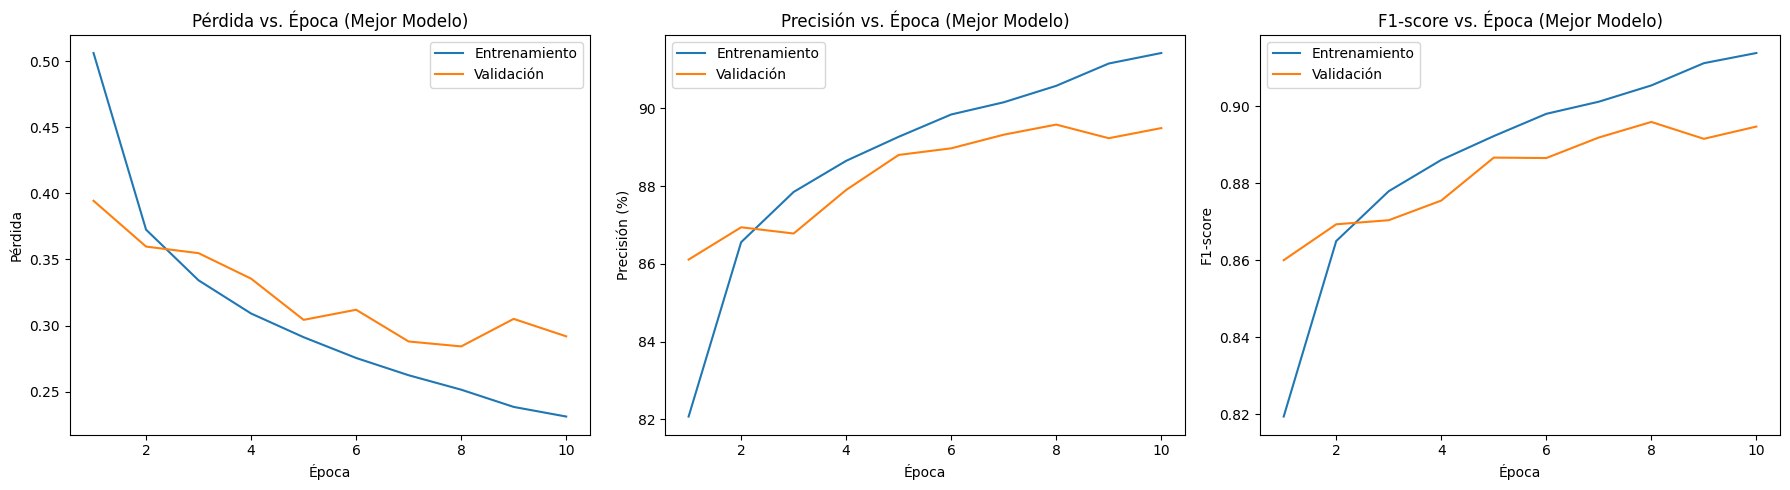

In [9]:
import matplotlib.pyplot as plt

# Generar gráficas para el mejor modelo
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), best_train_losses, label='Entrenamiento')
plt.plot(range(1, num_epochs + 1), best_valid_losses, label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida vs. Época (Mejor Modelo)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), best_train_accuracies, label='Entrenamiento')
plt.plot(range(1, num_epochs + 1), best_valid_accuracies, label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.title('Precisión vs. Época (Mejor Modelo)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), best_train_f1_scores, label='Entrenamiento')
plt.plot(range(1, num_epochs + 1), best_valid_f1_scores, label='Validación')
plt.xlabel('Época')
plt.ylabel('F1-score')
plt.title('F1-score vs. Época (Mejor Modelo)')
plt.legend()


plt.tight_layout()
plt.show()

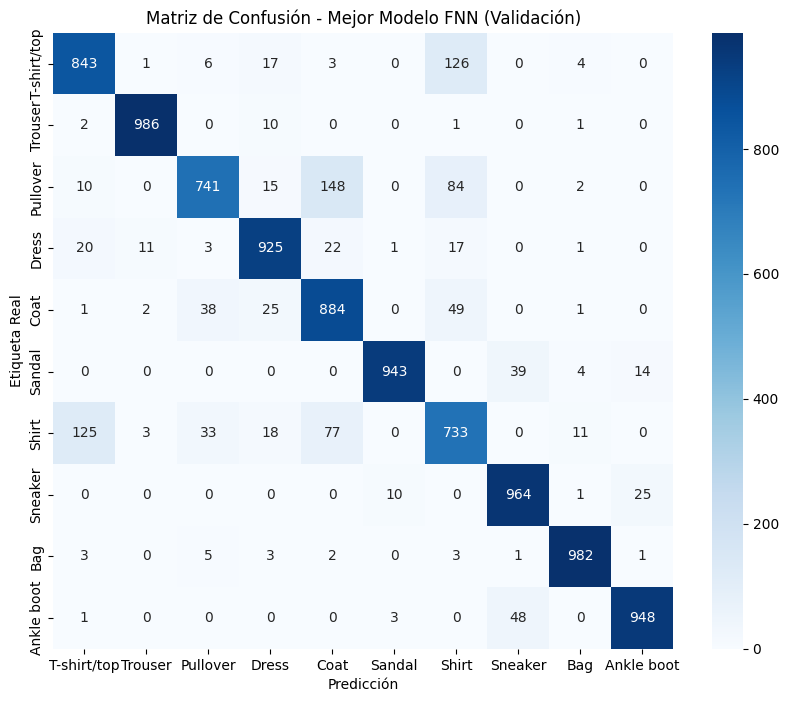

In [11]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Cargar el mejor modelo para la evaluación detallada
best_fnn_model = SimpleFNN(input_size, best_hyperparams['hidden_size'], num_classes).to(device)
if best_model_state is not None:
    best_fnn_model.load_state_dict(best_model_state)

valid_loader = DataLoader(valid_data, best_hyperparams['batch_size'], shuffle=False)

# Generación de Curvas ROC y Matriz de Confusión para el mejor modelo
best_fnn_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_fnn_model(images)
        probs = F.softmax(outputs, dim=1) # Obtener las probabilidades de cada clase
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generar Matriz de Confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - Mejor Modelo FNN (Validación)')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

## Análisis de Resultados

El modelo de Red Neuronal Feedforward (FNN) entrenado con los hiperparámetros optimizados (`hidden_size: 512`, `learning_rate: 0.001`, `batch_size: 32`) demostró un rendimiento prometedor en la tarea de clasificación del dataset FashionMNIST. Las gráficas de pérdida y precisión/F1-score durante el entrenamiento indicaron un aprendizaje efectivo, con una disminución constante de la pérdida y un aumento en la precisión y el F1-score tanto en el conjunto de entrenamiento como en el de validación. Sin embargo, se observó una ligera tendencia al sobreajuste hacia las últimas épocas, evidenciada por una estabilización o ligero aumento de la pérdida en el conjunto de validación.

El análisis de la matriz de confusión reveló que el modelo logró clasificar correctamente la mayoría de las instancias, especialmente en categorías con características visuales distintivas como 'Trouser', 'Sneaker', 'Bag' y 'Ankle boot'. No obstante, se identificaron confusiones significativas entre clases visualmente similares, como 'T-shirt/top' y 'Shirt', 'Pullover' y 'Coat', así como 'Pullover' y 'Shirt'. Estas confusiones sugieren que el modelo, basado únicamente en la información de los píxeles aplanados, tiene dificultades para discriminar entre prendas con siluetas o características generales parecidas.

En general, el modelo FNN proporciona una base sólida para la clasificación de FashionMNIST, alcanzando un buen nivel de precisión y F1-score en el conjunto de validación. Sin embargo, las confusiones observadas señalan la necesidad de explorar modelos que puedan capturar mejor las relaciones espaciales y las características locales de las imágenes, como las Redes Neuronales Convolucionales (CNNs), para potencialmente mejorar la discriminación entre las clases más similares. Los resultados obtenidos con este modelo FNN servirán como punto de referencia para evaluar el rendimiento de otros enfoques que se implementarán por otros integrantes del equipo.

---

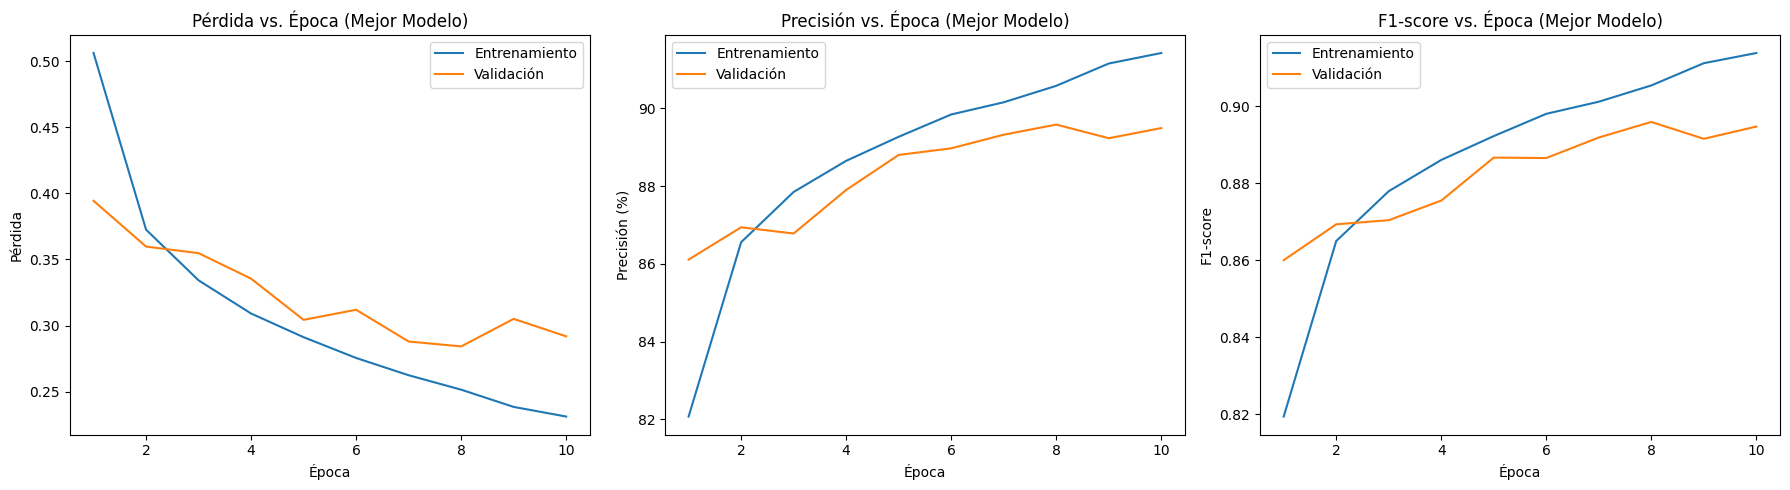

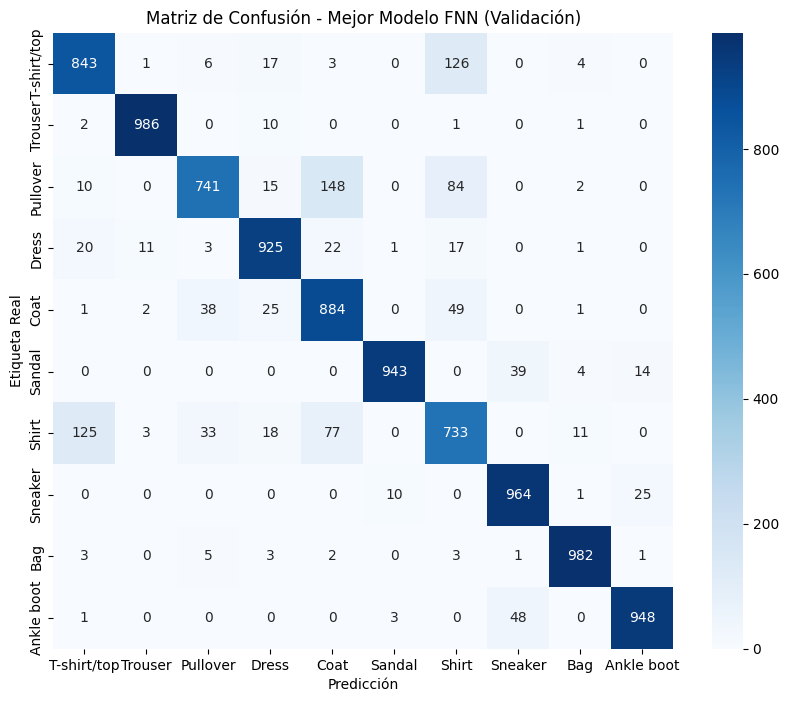